# BTC Preditive Model

In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-11-09,6377.99,6457.97,6352.45,6446.06,37086.04,2.378930e+08
2018-11-10,6396.37,6419.92,6376.17,6377.99,14658.42,9.431333e+07
2018-11-11,6408.18,6414.18,6326.38,6396.39,20337.03,1.301560e+08
2018-11-12,6375.08,6435.41,6350.87,6408.18,28338.62,1.815756e+08
2018-11-13,6339.17,6389.43,6315.58,6375.08,35761.27,2.276897e+08


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(hist, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


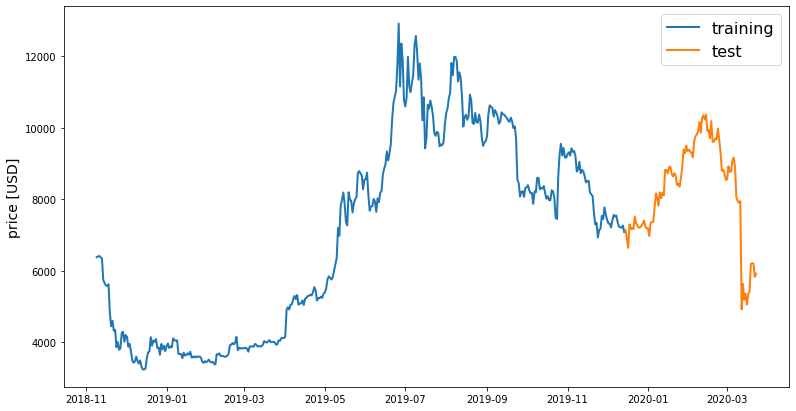

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [8]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [9]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [10]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [11]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### Modeling Variable

In [12]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 600
batch_size = 32
loss = 'mse'
dropout = 0.1
optimizer = 'adam'

In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [14]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/600
396/396 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 2/600
396/396 [==============================] - 0s 147us/step - loss: 0.0043
Epoch 3/600
396/396 [==============================] - 0s 159us/step - loss: 0.0034
Epoch 4/600
396/396 [==============================] - 0s 148us/step - loss: 0.0035
Epoch 5/600
396/396 [==============================] - 0s 137us/step - loss: 0.0032
Epoch 6/600
396/396 [==============================] - 0s 153us/step - loss: 0.0030
Epoch 7/600
396/396 [==============================] - 0s 159us/step - loss: 0.0029
Epoch 8/600
396/396 [==============================] - 0s 147us/step - loss: 0.0033
Epoch 9/600
396/396 [==============================] - 0s 143us/step - loss: 0.0027
Epoch 10/600
396/396 [==============================] - 0s 145us/step - loss: 0.0028
Epoch 11/600
396/396 [==============================] - 0s 159us/step - loss: 0.0026
Epoch 12/600
396/396 [==============================] - 0s 140us/step - loss

396/396 [==============================] - 0s 162us/step - loss: 0.0016
Epoch 98/600
396/396 [==============================] - 0s 148us/step - loss: 0.0015
Epoch 99/600
396/396 [==============================] - 0s 155us/step - loss: 0.0016
Epoch 100/600
396/396 [==============================] - 0s 130us/step - loss: 0.0016
Epoch 101/600
396/396 [==============================] - 0s 130us/step - loss: 0.0015
Epoch 102/600
396/396 [==============================] - 0s 131us/step - loss: 0.0016
Epoch 103/600
396/396 [==============================] - 0s 127us/step - loss: 0.0016
Epoch 104/600
396/396 [==============================] - 0s 129us/step - loss: 0.0015
Epoch 105/600
396/396 [==============================] - 0s 134us/step - loss: 0.0016
Epoch 106/600
396/396 [==============================] - 0s 131us/step - loss: 0.0017
Epoch 107/600
396/396 [==============================] - 0s 147us/step - loss: 0.0016
Epoch 108/600
396/396 [==============================] - 0s 140us/step

396/396 [==============================] - 0s 151us/step - loss: 0.0015
Epoch 193/600
396/396 [==============================] - 0s 137us/step - loss: 0.0015
Epoch 194/600
396/396 [==============================] - 0s 131us/step - loss: 0.0015
Epoch 195/600
396/396 [==============================] - 0s 125us/step - loss: 0.0014
Epoch 196/600
396/396 [==============================] - 0s 123us/step - loss: 0.0015
Epoch 197/600
396/396 [==============================] - 0s 130us/step - loss: 0.0016
Epoch 198/600
396/396 [==============================] - 0s 134us/step - loss: 0.0015
Epoch 199/600
396/396 [==============================] - 0s 138us/step - loss: 0.0014
Epoch 200/600
396/396 [==============================] - 0s 130us/step - loss: 0.0015
Epoch 201/600
396/396 [==============================] - 0s 136us/step - loss: 0.0015
Epoch 202/600
396/396 [==============================] - 0s 131us/step - loss: 0.0015
Epoch 203/600
396/396 [==============================] - 0s 135us/st

396/396 [==============================] - 0s 140us/step - loss: 0.0013
Epoch 288/600
396/396 [==============================] - 0s 139us/step - loss: 0.0013
Epoch 289/600
396/396 [==============================] - 0s 139us/step - loss: 0.0013
Epoch 290/600
396/396 [==============================] - 0s 142us/step - loss: 0.0014
Epoch 291/600
396/396 [==============================] - 0s 143us/step - loss: 0.0013
Epoch 292/600
396/396 [==============================] - 0s 141us/step - loss: 0.0013
Epoch 293/600
396/396 [==============================] - 0s 140us/step - loss: 0.0013
Epoch 294/600
396/396 [==============================] - 0s 141us/step - loss: 0.0013
Epoch 295/600
396/396 [==============================] - 0s 139us/step - loss: 0.0013
Epoch 296/600
396/396 [==============================] - 0s 138us/step - loss: 0.0013
Epoch 297/600
396/396 [==============================] - 0s 144us/step - loss: 0.0013
Epoch 298/600
396/396 [==============================] - 0s 140us/st

396/396 [==============================] - 0s 137us/step - loss: 0.0012
Epoch 383/600
396/396 [==============================] - 0s 134us/step - loss: 0.0012
Epoch 384/600
396/396 [==============================] - 0s 139us/step - loss: 0.0012
Epoch 385/600
396/396 [==============================] - 0s 133us/step - loss: 0.0012
Epoch 386/600
396/396 [==============================] - 0s 131us/step - loss: 0.0012
Epoch 387/600
396/396 [==============================] - 0s 132us/step - loss: 0.0011
Epoch 388/600
396/396 [==============================] - 0s 134us/step - loss: 0.0011
Epoch 389/600
396/396 [==============================] - 0s 137us/step - loss: 0.0012
Epoch 390/600
396/396 [==============================] - 0s 139us/step - loss: 0.0013
Epoch 391/600
396/396 [==============================] - 0s 137us/step - loss: 0.0013
Epoch 392/600
396/396 [==============================] - 0s 143us/step - loss: 0.0012
Epoch 393/600
396/396 [==============================] - 0s 140us/st

396/396 [==============================] - 0s 132us/step - loss: 0.0012
Epoch 478/600
396/396 [==============================] - 0s 134us/step - loss: 0.0011
Epoch 479/600
396/396 [==============================] - 0s 134us/step - loss: 0.0011
Epoch 480/600
396/396 [==============================] - 0s 137us/step - loss: 0.0011
Epoch 481/600
396/396 [==============================] - 0s 132us/step - loss: 0.0011
Epoch 482/600
396/396 [==============================] - 0s 127us/step - loss: 0.0011
Epoch 483/600
396/396 [==============================] - 0s 126us/step - loss: 0.0011
Epoch 484/600
396/396 [==============================] - 0s 133us/step - loss: 0.0011
Epoch 485/600
396/396 [==============================] - 0s 127us/step - loss: 0.0011
Epoch 486/600
396/396 [==============================] - 0s 131us/step - loss: 0.0011
Epoch 487/600
396/396 [==============================] - 0s 129us/step - loss: 0.0011
Epoch 488/600
396/396 [==============================] - 0s 128us/st

396/396 [==============================] - 0s 128us/step - loss: 9.9966e-04
Epoch 573/600
396/396 [==============================] - 0s 129us/step - loss: 0.0010
Epoch 574/600
396/396 [==============================] - 0s 131us/step - loss: 0.0011
Epoch 575/600
396/396 [==============================] - 0s 124us/step - loss: 0.0010
Epoch 576/600
396/396 [==============================] - 0s 125us/step - loss: 0.0010
Epoch 577/600
396/396 [==============================] - 0s 126us/step - loss: 9.5550e-04
Epoch 578/600
396/396 [==============================] - 0s 133us/step - loss: 9.7518e-04
Epoch 579/600
396/396 [==============================] - 0s 129us/step - loss: 0.0010
Epoch 580/600
396/396 [==============================] - 0s 125us/step - loss: 0.0010
Epoch 581/600
396/396 [==============================] - 0s 128us/step - loss: 0.0010
Epoch 582/600
396/396 [==============================] - 0s 128us/step - loss: 0.0011
Epoch 583/600
396/396 [==============================] -

In [15]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03925767040990324

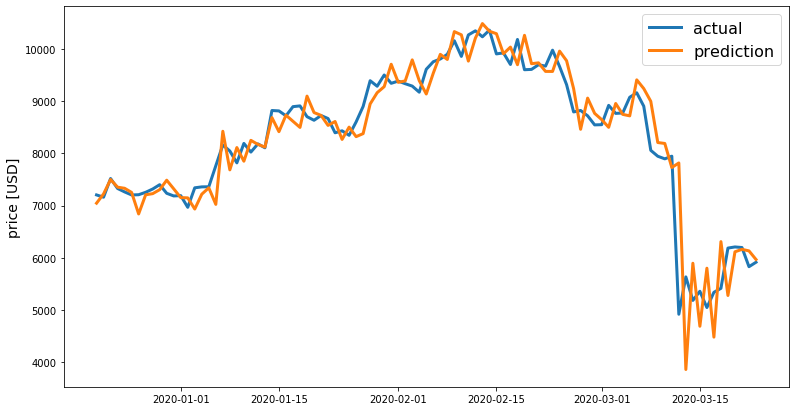

In [16]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# ETH Predictive Model

In [17]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [18]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-11-09,209.39,213.54,207.54,211.29,223676.06,47121564.81
2018-11-10,211.90,214.61,209.04,209.39,139451.69,29624413.93
2018-11-11,211.70,212.56,206.61,211.90,167900.44,35300337.83
2018-11-12,210.81,213.21,208.97,211.70,197311.94,41671998.96
2018-11-13,206.42,210.93,205.66,210.81,281633.62,58600617.76


In [19]:
train, test = train_test_split(hist, test_size=0.2)

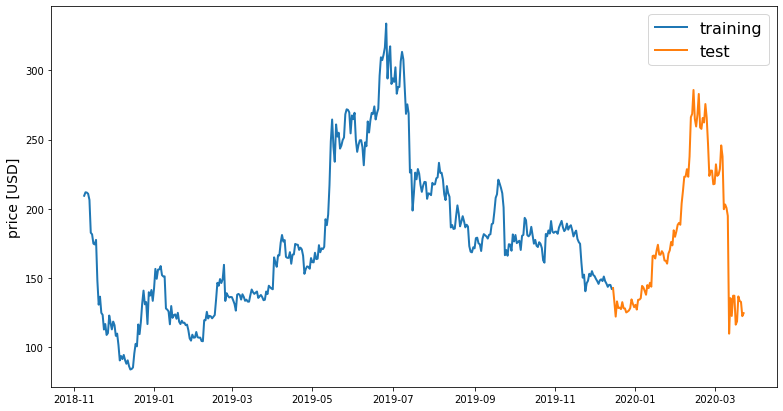

In [20]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [21]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [22]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/600
396/396 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 2/600
396/396 [==============================] - 0s 162us/step - loss: 0.0053
Epoch 3/600
396/396 [==============================] - 0s 157us/step - loss: 0.0047
Epoch 4/600
396/396 [==============================] - 0s 157us/step - loss: 0.0044
Epoch 5/600
396/396 [==============================] - 0s 157us/step - loss: 0.0041
Epoch 6/600
396/396 [==============================] - 0s 159us/step - loss: 0.0043
Epoch 7/600
396/396 [==============================] - 0s 152us/step - loss: 0.0042
Epoch 8/600
396/396 [==============================] - 0s 144us/step - loss: 0.0040
Epoch 9/600
396/396 [==============================] - 0s 141us/step - loss: 0.0035
Epoch 10/600
396/396 [==============================] - 0s 140us/step - loss: 0.0040
Epoch 11/600
396/396 [==============================] - 0s 137us/step - loss: 0.0036
Epoch 12/600
396/396 [==============================] - 0s 153us/step - loss

396/396 [==============================] - 0s 139us/step - loss: 0.0022
Epoch 98/600
396/396 [==============================] - 0s 137us/step - loss: 0.0023
Epoch 99/600
396/396 [==============================] - 0s 137us/step - loss: 0.0022
Epoch 100/600
396/396 [==============================] - 0s 133us/step - loss: 0.0022
Epoch 101/600
396/396 [==============================] - 0s 130us/step - loss: 0.0023
Epoch 102/600
396/396 [==============================] - 0s 131us/step - loss: 0.0022
Epoch 103/600
396/396 [==============================] - 0s 135us/step - loss: 0.0022
Epoch 104/600
396/396 [==============================] - 0s 129us/step - loss: 0.0023
Epoch 105/600
396/396 [==============================] - 0s 131us/step - loss: 0.0023
Epoch 106/600
396/396 [==============================] - 0s 133us/step - loss: 0.0023
Epoch 107/600
396/396 [==============================] - 0s 130us/step - loss: 0.0024
Epoch 108/600
396/396 [==============================] - 0s 136us/step

396/396 [==============================] - 0s 143us/step - loss: 0.0021
Epoch 193/600
396/396 [==============================] - 0s 131us/step - loss: 0.0022
Epoch 194/600
396/396 [==============================] - 0s 132us/step - loss: 0.0021
Epoch 195/600
396/396 [==============================] - 0s 136us/step - loss: 0.0022
Epoch 196/600
396/396 [==============================] - 0s 134us/step - loss: 0.0021
Epoch 197/600
396/396 [==============================] - 0s 129us/step - loss: 0.0022
Epoch 198/600
396/396 [==============================] - 0s 131us/step - loss: 0.0021
Epoch 199/600
396/396 [==============================] - 0s 133us/step - loss: 0.0021
Epoch 200/600
396/396 [==============================] - 0s 135us/step - loss: 0.0022
Epoch 201/600
396/396 [==============================] - 0s 131us/step - loss: 0.0022
Epoch 202/600
396/396 [==============================] - 0s 130us/step - loss: 0.0022
Epoch 203/600
396/396 [==============================] - 0s 132us/st

396/396 [==============================] - 0s 135us/step - loss: 0.0020
Epoch 288/600
396/396 [==============================] - 0s 132us/step - loss: 0.0020
Epoch 289/600
396/396 [==============================] - 0s 131us/step - loss: 0.0019
Epoch 290/600
396/396 [==============================] - 0s 140us/step - loss: 0.0020
Epoch 291/600
396/396 [==============================] - 0s 140us/step - loss: 0.0019
Epoch 292/600
396/396 [==============================] - 0s 136us/step - loss: 0.0020
Epoch 293/600
396/396 [==============================] - 0s 130us/step - loss: 0.0020
Epoch 294/600
396/396 [==============================] - 0s 141us/step - loss: 0.0019
Epoch 295/600
396/396 [==============================] - 0s 133us/step - loss: 0.0019
Epoch 296/600
396/396 [==============================] - 0s 129us/step - loss: 0.0019
Epoch 297/600
396/396 [==============================] - 0s 126us/step - loss: 0.0019
Epoch 298/600
396/396 [==============================] - 0s 128us/st

396/396 [==============================] - 0s 134us/step - loss: 0.0018
Epoch 383/600
396/396 [==============================] - 0s 130us/step - loss: 0.0017
Epoch 384/600
396/396 [==============================] - 0s 128us/step - loss: 0.0017
Epoch 385/600
396/396 [==============================] - 0s 125us/step - loss: 0.0018
Epoch 386/600
396/396 [==============================] - 0s 125us/step - loss: 0.0017
Epoch 387/600
396/396 [==============================] - 0s 159us/step - loss: 0.0017
Epoch 388/600
396/396 [==============================] - 0s 126us/step - loss: 0.0017
Epoch 389/600
396/396 [==============================] - 0s 125us/step - loss: 0.0018
Epoch 390/600
396/396 [==============================] - 0s 126us/step - loss: 0.0017
Epoch 391/600
396/396 [==============================] - 0s 124us/step - loss: 0.0017
Epoch 392/600
396/396 [==============================] - 0s 125us/step - loss: 0.0018
Epoch 393/600
396/396 [==============================] - 0s 143us/st

396/396 [==============================] - 0s 132us/step - loss: 0.0017
Epoch 478/600
396/396 [==============================] - 0s 139us/step - loss: 0.0016
Epoch 479/600
396/396 [==============================] - 0s 134us/step - loss: 0.0016
Epoch 480/600
396/396 [==============================] - 0s 136us/step - loss: 0.0017
Epoch 481/600
396/396 [==============================] - 0s 130us/step - loss: 0.0015
Epoch 482/600
396/396 [==============================] - 0s 132us/step - loss: 0.0015
Epoch 483/600
396/396 [==============================] - 0s 133us/step - loss: 0.0015
Epoch 484/600
396/396 [==============================] - 0s 137us/step - loss: 0.0016
Epoch 485/600
396/396 [==============================] - 0s 136us/step - loss: 0.0016
Epoch 486/600
396/396 [==============================] - 0s 131us/step - loss: 0.0016
Epoch 487/600
396/396 [==============================] - 0s 134us/step - loss: 0.0017
Epoch 488/600
396/396 [==============================] - 0s 142us/st

396/396 [==============================] - 0s 135us/step - loss: 0.0014
Epoch 573/600
396/396 [==============================] - 0s 135us/step - loss: 0.0014
Epoch 574/600
396/396 [==============================] - 0s 140us/step - loss: 0.0013
Epoch 575/600
396/396 [==============================] - 0s 133us/step - loss: 0.0014
Epoch 576/600
396/396 [==============================] - 0s 131us/step - loss: 0.0014
Epoch 577/600
396/396 [==============================] - 0s 138us/step - loss: 0.0014
Epoch 578/600
396/396 [==============================] - 0s 145us/step - loss: 0.0014
Epoch 579/600
396/396 [==============================] - 0s 135us/step - loss: 0.0014
Epoch 580/600
396/396 [==============================] - 0s 134us/step - loss: 0.0015
Epoch 581/600
396/396 [==============================] - 0s 130us/step - loss: 0.0014
Epoch 582/600
396/396 [==============================] - 0s 136us/step - loss: 0.0014
Epoch 583/600
396/396 [==============================] - 0s 133us/st

In [23]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.06355322572052204

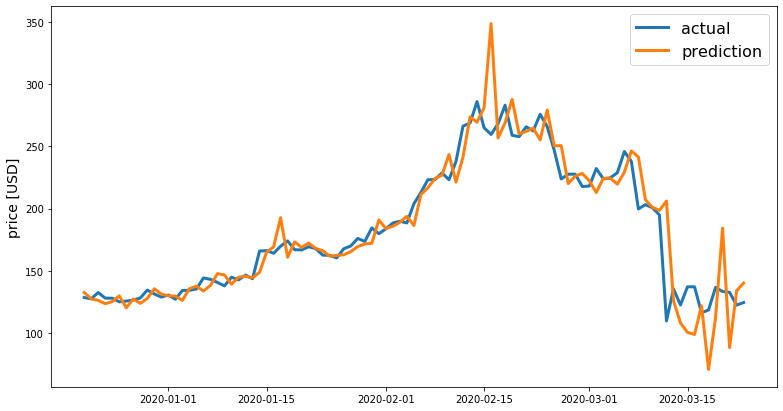

In [24]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# LTC Preditive Model

In [25]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=LTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [26]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-11-09,51.89,52.65,51.31,52.28,131155.39,6816154.86
2018-11-10,52.18,52.55,51.67,51.89,63220.37,3298761.03
2018-11-11,51.12,52.23,49.76,52.18,146926.41,7468914.08
2018-11-12,50.68,51.62,50.29,51.12,122663.96,6230682.86
2018-11-13,49.42,50.84,48.85,50.68,185451.18,9273328.48


In [27]:
train, test = train_test_split(hist, test_size=0.2)

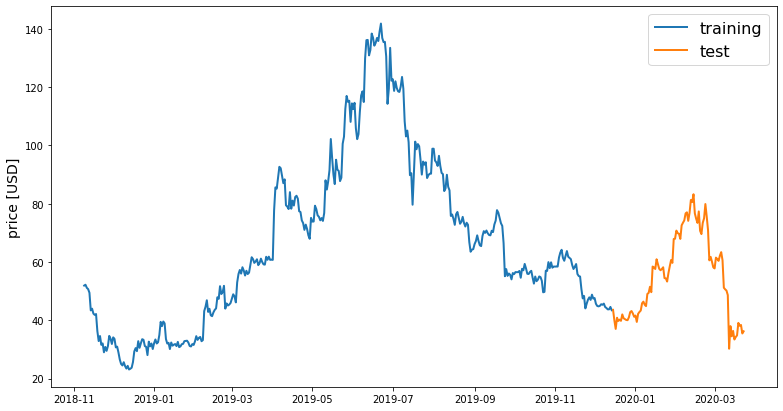

In [28]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [29]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/600
396/396 [==============================] - 1s 1ms/step - loss: 0.0244
Epoch 2/600
396/396 [==============================] - 0s 161us/step - loss: 0.0092
Epoch 3/600
396/396 [==============================] - 0s 159us/step - loss: 0.0078
Epoch 4/600
396/396 [==============================] - 0s 159us/step - loss: 0.0066
Epoch 5/600
396/396 [==============================] - 0s 153us/step - loss: 0.0053
Epoch 6/600
396/396 [==============================] - 0s 144us/step - loss: 0.0055
Epoch 7/600
396/396 [==============================] - 0s 150us/step - loss: 0.0052
Epoch 8/600
396/396 [==============================] - 0s 162us/step - loss: 0.0048
Epoch 9/600
396/396 [==============================] - 0s 152us/step - loss: 0.0049
Epoch 10/600
396/396 [==============================] - 0s 146us/step - loss: 0.0045
Epoch 11/600
396/396 [==============================] - 0s 149us/step - loss: 0.0043
Epoch 12/600
396/396 [==============================] - 0s 163us/step - loss

396/396 [==============================] - 0s 137us/step - loss: 0.0028
Epoch 98/600
396/396 [==============================] - 0s 135us/step - loss: 0.0028
Epoch 99/600
396/396 [==============================] - 0s 133us/step - loss: 0.0027
Epoch 100/600
396/396 [==============================] - 0s 133us/step - loss: 0.0027
Epoch 101/600
396/396 [==============================] - 0s 132us/step - loss: 0.0027
Epoch 102/600
396/396 [==============================] - 0s 136us/step - loss: 0.0028
Epoch 103/600
396/396 [==============================] - 0s 127us/step - loss: 0.0028
Epoch 104/600
396/396 [==============================] - 0s 129us/step - loss: 0.0028
Epoch 105/600
396/396 [==============================] - 0s 138us/step - loss: 0.0028
Epoch 106/600
396/396 [==============================] - 0s 132us/step - loss: 0.0027
Epoch 107/600
396/396 [==============================] - 0s 132us/step - loss: 0.0028
Epoch 108/600
396/396 [==============================] - 0s 133us/step

396/396 [==============================] - 0s 137us/step - loss: 0.0026
Epoch 193/600
396/396 [==============================] - 0s 149us/step - loss: 0.0026
Epoch 194/600
396/396 [==============================] - 0s 134us/step - loss: 0.0026
Epoch 195/600
396/396 [==============================] - 0s 132us/step - loss: 0.0025
Epoch 196/600
396/396 [==============================] - 0s 138us/step - loss: 0.0025
Epoch 197/600
396/396 [==============================] - 0s 130us/step - loss: 0.0024
Epoch 198/600
396/396 [==============================] - 0s 130us/step - loss: 0.0026
Epoch 199/600
396/396 [==============================] - 0s 133us/step - loss: 0.0025
Epoch 200/600
396/396 [==============================] - 0s 139us/step - loss: 0.0026
Epoch 201/600
396/396 [==============================] - 0s 136us/step - loss: 0.0025
Epoch 202/600
396/396 [==============================] - 0s 136us/step - loss: 0.0025
Epoch 203/600
396/396 [==============================] - 0s 138us/st

396/396 [==============================] - 0s 130us/step - loss: 0.0024
Epoch 288/600
396/396 [==============================] - 0s 135us/step - loss: 0.0024
Epoch 289/600
396/396 [==============================] - 0s 129us/step - loss: 0.0024
Epoch 290/600
396/396 [==============================] - 0s 130us/step - loss: 0.0025
Epoch 291/600
396/396 [==============================] - 0s 129us/step - loss: 0.0024
Epoch 292/600
396/396 [==============================] - 0s 133us/step - loss: 0.0024
Epoch 293/600
396/396 [==============================] - 0s 132us/step - loss: 0.0024
Epoch 294/600
396/396 [==============================] - 0s 132us/step - loss: 0.0024
Epoch 295/600
396/396 [==============================] - 0s 133us/step - loss: 0.0024
Epoch 296/600
396/396 [==============================] - 0s 130us/step - loss: 0.0025
Epoch 297/600
396/396 [==============================] - 0s 132us/step - loss: 0.0025
Epoch 298/600
396/396 [==============================] - 0s 131us/st

396/396 [==============================] - 0s 135us/step - loss: 0.0023
Epoch 383/600
396/396 [==============================] - 0s 143us/step - loss: 0.0023
Epoch 384/600
396/396 [==============================] - 0s 147us/step - loss: 0.0023
Epoch 385/600
396/396 [==============================] - 0s 130us/step - loss: 0.0023
Epoch 386/600
396/396 [==============================] - 0s 136us/step - loss: 0.0024
Epoch 387/600
396/396 [==============================] - 0s 135us/step - loss: 0.0023
Epoch 388/600
396/396 [==============================] - 0s 132us/step - loss: 0.0023
Epoch 389/600
396/396 [==============================] - 0s 134us/step - loss: 0.0023
Epoch 390/600
396/396 [==============================] - 0s 130us/step - loss: 0.0023
Epoch 391/600
396/396 [==============================] - 0s 145us/step - loss: 0.0023
Epoch 392/600
396/396 [==============================] - 0s 145us/step - loss: 0.0024
Epoch 393/600
396/396 [==============================] - 0s 139us/st

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)